In [1]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy import stats

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ

from lib.file.ROI_reader import ROIFileReader
from lib.file.ROI_writer import ROIFileWriter
from lib.analysis.laminar_dist import LaminarROI, Line, ROICreator
from lib.analysis.align import ImageAlign
from lib.analysis.cell_roi import RandomROISample
from lib.utilities import *

####################################################################################
#    Build a hw vs dist scatter and amp vs dist scatter for all high-SNR px for all
#       of Kate's data
#    Use t-test to determine if correlation is significant
#    Addition:
#       Titrate the size of the ROIs
#          - generate ROI file of random sample of circle ROIs of n_pixels px per ROI
#       Also titrate the SNR cutoff
#          - get more ROI sizes to 20 or 25
#          - plot average of 1-10px ROI sizes for various SNR percentile cutoffs
#          - percentile cutoff should range from 5% to 20%
####################################################################################

In [2]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/"
# data_dir = 'C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/'

enable_photoZ_interaction = False
initialize_photoZ = True
snr_cutoff_signal = 3.0
amp_cutoff = 3.0

snr_cutoffs_titrate = [5 + i for i in range(25)]  # since cutoff is per recording, only whole numbers make sense (there are 100 ROIs/rec/roi_size)
roi_sizes = [i for i in range(1,26)] #[11, 13, 15, 17, 19, 21, 22, 23, 24, 25]
create_roi_files = False  # if False, assumes roi files exist

In [3]:
# set up PhotoZ (open it manually)
if enable_photoZ_interaction:
    aPhz = AutoPhotoZ(data_dir=data_dir)
    if initialize_photoZ:
        aPhz.prepare_photoZ(select=False)

In [4]:
# Generate ROI files of specified sizes
roi_files = []
roi_center_files = []
rfw = ROIFileWriter()
for rsz in roi_sizes:

    # file naming
    filename = data_dir + "ROIs_size_" + str(rsz) + "px.dat"
    roi_files.append(filename)
    ctr_fn = data_dir + "ROIs_centers_" + str(rsz) + "px.dat"
    roi_center_files.append(ctr_fn)
    if create_roi_files:
        roi_sampler = RandomROISample(rsz)

        # return list of lists of pairs (px)
        roi_list = roi_sampler.take_random_sample()
        
        # write centers to file for later use
        roi_center_list = roi_sampler.get_roi_centers()

        with open(ctr_fn, 'w') as f:
            for center in roi_center_list:
                f.write(str(center) + "\n")

        # convert to diode numbers for file writing
        roi_list = ROICreator(None).convert_rois_to_diode_numbers(roi_list)

        # write to file
        rfw.write_regions_to_dat(filename, roi_list)

In [5]:
data_map = {}
is_photoZ_selected = False
# extract all hw and amp files 
for subdir, dirs, files in os.walk(data_dir):
    if 'hidden' in subdir:
        continue
    for zda_file in files:
        if zda_file.endswith('.zda'):
            zda_filepath = subdir + "/" + zda_file
            print(zda_filepath)
            if enable_photoZ_interaction:
                aPhz = AutoPhotoZ(data_dir=subdir,
                                  skip_select_photoZ=True)
                # open the PhotoZ file
                if not is_photoZ_selected:
                    # aPhz.select_PhotoZ()
                    is_photoZ_selected = True

                print("\n\nOpening", zda_file)
                aPhz.open_zda_file(zda_filepath)
                time.sleep(5)

            data_map[subdir] = {}
            for i in range(len(roi_files)):
                roi_file = roi_files[i]
                roi_size = roi_sizes[i]
                roi_suffix = "_" + str(roi_sizes[i]) + "px"
                snr_filename = subdir + "/" + "SNR" + roi_suffix + ".dat"
                hw_filename = subdir + "/" + "hw" + roi_suffix + ".dat" 
                amp_filename = subdir + "/" + "amp" + roi_suffix + ".dat"

                data_map[subdir][roi_size] = {"SNR": snr_filename,
                                             "hw": hw_filename,
                                             "amp": amp_filename}

                if all([os.path.exists(x) for x in 
                            [snr_filename, hw_filename, amp_filename]]):
                    continue

                # Open the ROI file 
                if enable_photoZ_interaction:
                    aPhz.select_roi_tab()
                    aPhz.open_roi_file(roi_file)
                    time.sleep(5)

                # save SNR values from PhotoZ
                if enable_photoZ_interaction:
                    aPhz.select_SNR_trace_value()
                    aPhz.save_trace_values(snr_filename)

                # save half-width values from PhotoZ
                if enable_photoZ_interaction:
                    aPhz.select_half_width_trace_value()
                    aPhz.save_trace_values(hw_filename)

                # save latency values from PhotoZ
                if enable_photoZ_interaction:
                    aPhz.select_maxamp_trace_value()
                    aPhz.save_trace_values(amp_filename)


C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-13_02-01-02_L4_intralaminar/02_01_02.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_03-01-08_aka_02-01-08_L23_intralaminar/02_01_08.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_04-01-01_aka_03-01-01_L4_interlaminar/03_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_06-01-01_aka_part2_03-01-01_L4_interlaminar/03_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_08-01-04_aka_part2_05-01-04_L4_interlaminar/05_01_04.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_10-01-01_aka_part2_07-01-01_L4_interlaminar/07_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_11-01-06_aka_part2_08-01-06_L4_interlaminar/

In [27]:
# for each subdir, take all hw/amp/electrode dist of points with SNR > cutoff
def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Diode Number',  'Value'])
    return data_arr

def read_dat_arr_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Value'])
    data_arr = np.array(data_arr['Value']).reshape((80, 80))
    return data_arr
    
concat_data = pd.DataFrame({})
snr_dfs = []
total_pre_filter = 0
for subdir in data_map:

    # open stim point roi as a single integer (its diode number) in variable stim_pt
    sp_file = subdir + "/" + 'electrode.dat'
    with open(sp_file, 'r') as f:
        lines = f.readlines()
    stim_pt = int(lines[-1]) # last line is always electrode location
    aux_obj = LaminarROI([stim_pt]).get_points()
    stim_pt = aux_obj[0]  # should be a list of len 2, representing px location [x, y]
    
    for i in range(len(roi_sizes)):
        roi_size = roi_sizes[i]
        if roi_size not in data_map[subdir]:
            continue
        dm = data_map[subdir][roi_size]

        # read in data files if they exist
        try:
            amp = read_dat_trace_file(dm['amp'])
            hw = read_dat_trace_file(dm['hw'])
            snr = read_dat_trace_file(dm['SNR'])
        except Exception as e:
            print(e)
            continue
            
        total_pre_filter += len(amp['Value'])
            
        snr = snr.join(amp, rsuffix='amp')
        snr = snr.join(hw, rsuffix='hw')

        # Find distance from diode number to stim_pt
        roi_center_filename = roi_center_files[i]
        with open(roi_center_filename, 'r') as f:
            lines = f.readlines()
        centers_split = [x.strip("[]\n").split(', ')
                             for x in lines]
        centers = [[int(y[0]), int(y[1])] for y in centers_split]
        dist = []
        for ctr_px in centers:
            d = Line(stim_pt, ctr_px).get_length()
            dist.append(d * 6)  # convert px -> um

        snr.insert(4, 'electrode_dist', dist)
        roi_size_col = [roi_size for _ in dist]
        snr.insert(5, 'roi_size', roi_size_col)
        snr.insert(6, 'recording_id', [subdir for _ in dist])

        snr = snr[pd.to_numeric(snr.Value, errors='coerce').notnull()]


        snr_dfs.append(snr)

pre_filter_snr = pd.concat(snr_dfs)
pre_filter_snr["Valueamp"] = pd.to_numeric(pre_filter_snr["Valueamp"])
print(total_pre_filter)

# now some filtering
all_snr = pre_filter_snr[pre_filter_snr['Value'] > snr_cutoff_signal]
all_snr = all_snr[all_snr['Valuehw'] > 0]
all_snr = all_snr[all_snr['Valuehw'] < 15]
all_snr = all_snr[all_snr['Valueamp'] > amp_cutoff]

# not close to electrode
all_snr = all_snr[all_snr['electrode_dist'] > 100]
all_snr

[Errno 2] No such file or directory: "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_11-01-06_aka_part2_08-01-06_L4_interlaminar/amp_18px.dat"
[Errno 2] No such file or directory: "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2020-12-28_11-01-06_aka_part2_08-01-06_L4_interlaminar/amp_20px.dat"
[Errno 2] No such file or directory: "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2021-01-18_05-01-03_L23_interlaminar/SNR_5px.dat"
[Errno 2] No such file or directory: "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2021-01-18_05-01-03_L23_interlaminar/amp_20px.dat"
[Errno 2] No such file or directory: "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/2021-03-09_03-01-02_L5_interlaminar/amp_20px.dat"
[Errno 2] No such file or directory: "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatt

,Diode Number,Value,Diode Numberamp,Valueamp,electrode_dist,roi_size,recording_id,Diode Numberhw,Valuehw
17,18,3.25216,18,3.12042,126.142776,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,18,6.93848
20,21,3.08410,21,3.06005,258.627145,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,21,2.97926
25,26,3.74438,26,4.71711,252.071418,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,26,1.63418
27,28,4.89686,28,4.38483,123.109707,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,28,3.43574
28,29,4.25345,29,3.74361,207.238992,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,29,2.60935
...,...,...,...,...,...,...,...,...,...
91,92,8.59535,92,4.20654,434.699896,25,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,92,3.35845
92,93,7.08039,93,3.50378,390.875939,25,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,93,6.83033
94,95,14.52360,95,4.17098,276.586334,25,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,95,3.03311
95,96,5.09618,96,4.17993,483.623821,25,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,96,5.37504


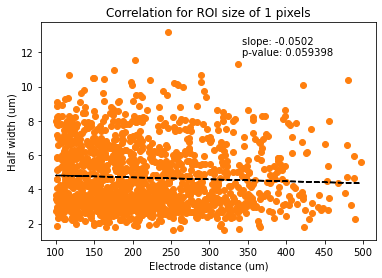

p-value for hw: 0.05939849726778885


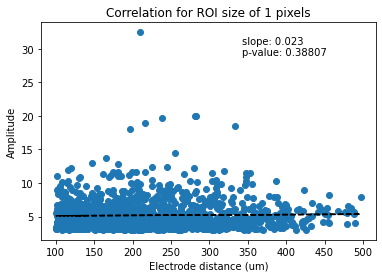

p-value for amp: 0.38807009868685616


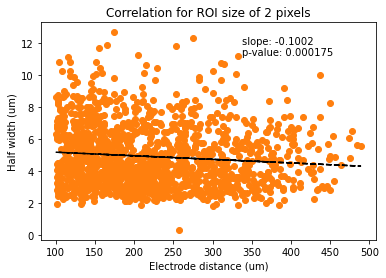

p-value for hw: 0.0001750655871378822


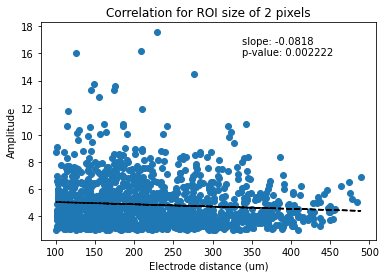

p-value for amp: 0.002222398619042472


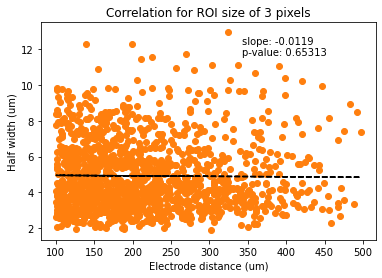

p-value for hw: 0.6531297887566532


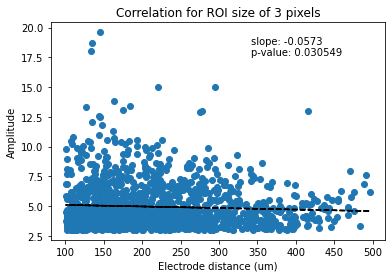

p-value for amp: 0.03054872060991292


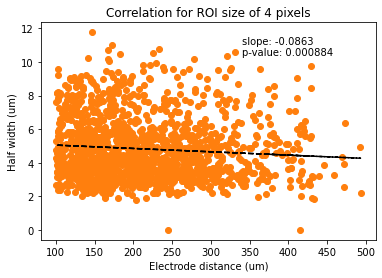

p-value for hw: 0.000884230568495548


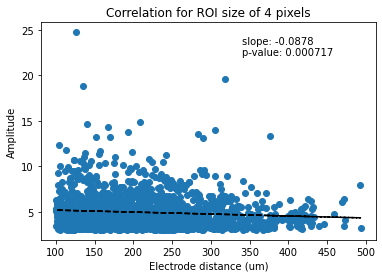

p-value for amp: 0.0007171527063985453


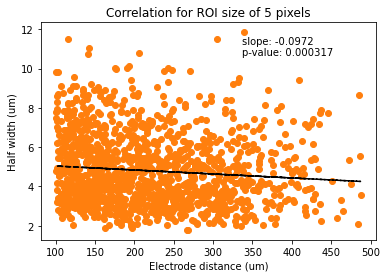

p-value for hw: 0.0003168043754997774


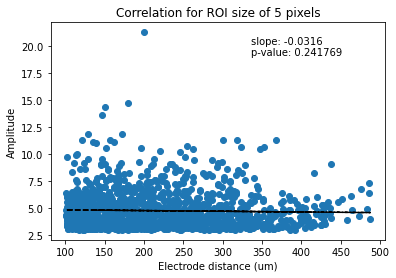

p-value for amp: 0.2417694437557637


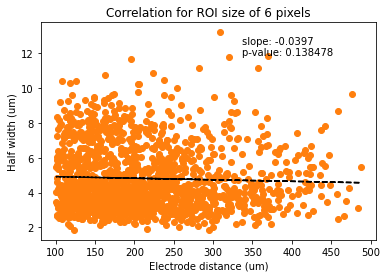

p-value for hw: 0.13847841851743356


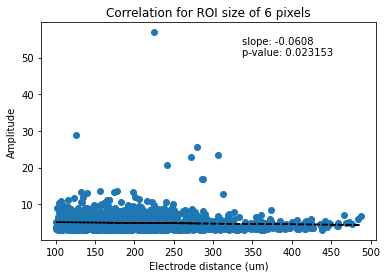

p-value for amp: 0.023153321322667078


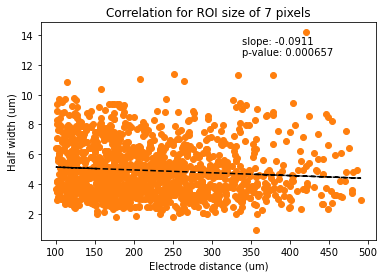

p-value for hw: 0.0006566235845282868


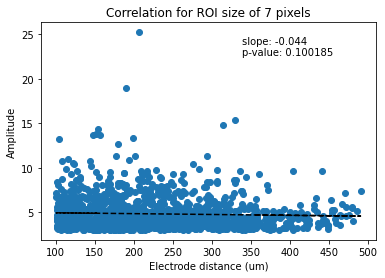

p-value for amp: 0.10018540277309847


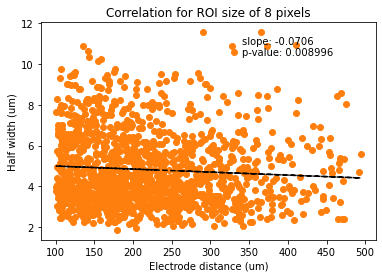

p-value for hw: 0.008996222340671357


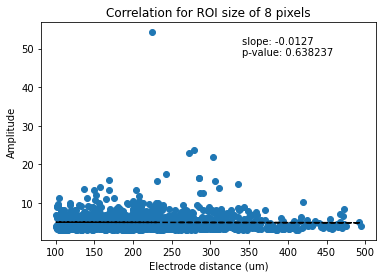

p-value for amp: 0.6382373729024347


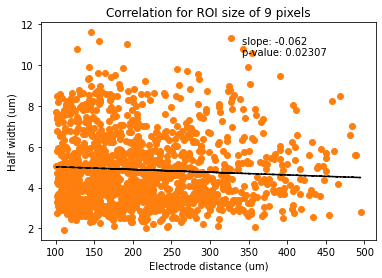

p-value for hw: 0.023070157291745334


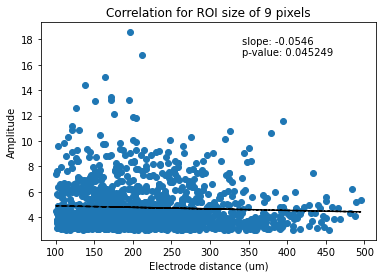

p-value for amp: 0.04524880043654166


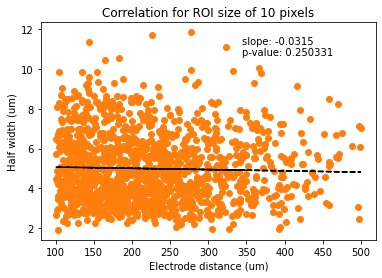

p-value for hw: 0.2503312589375581


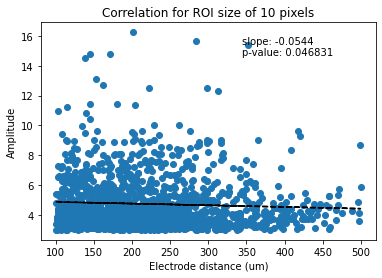

p-value for amp: 0.04683136487857507


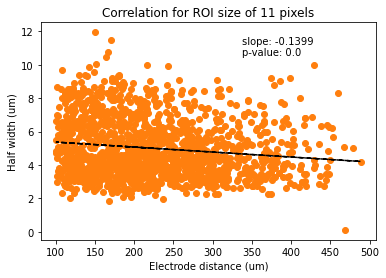

p-value for hw: 1.5079286678629476e-07


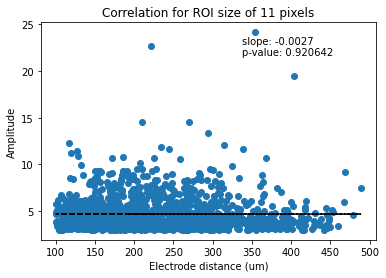

p-value for amp: 0.9206422163739247


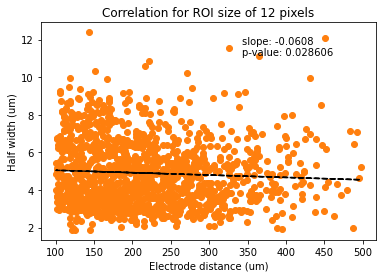

p-value for hw: 0.028605673921144086


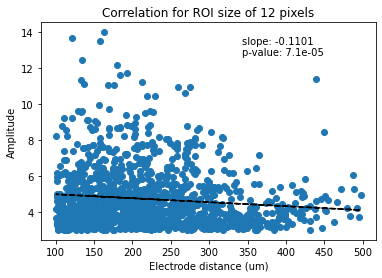

p-value for amp: 7.146045726525506e-05


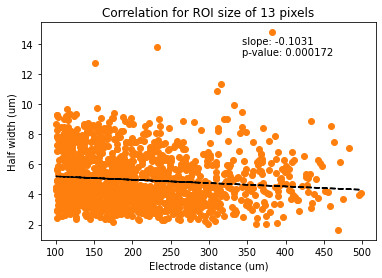

p-value for hw: 0.0001722915536918396


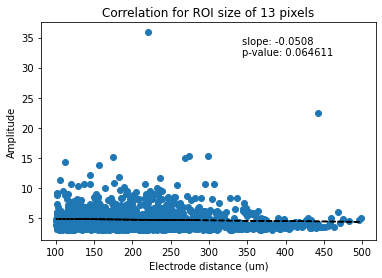

p-value for amp: 0.06461052196180506


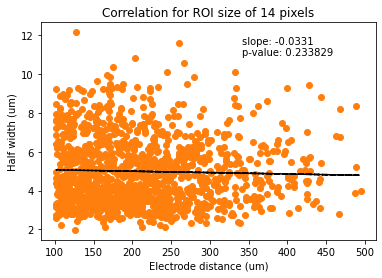

p-value for hw: 0.2338294906871295


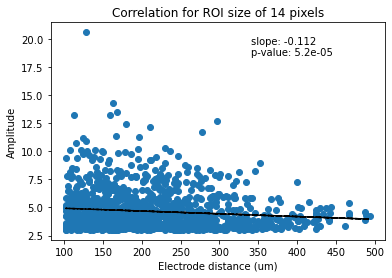

p-value for amp: 5.229141592721538e-05


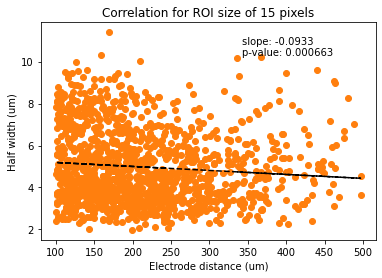

p-value for hw: 0.0006633322818796484


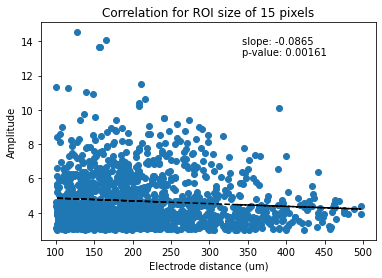

p-value for amp: 0.0016102850170400338


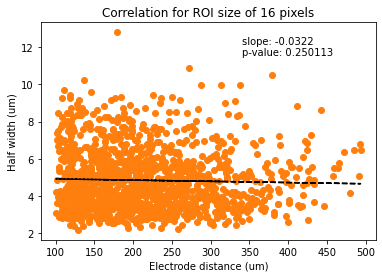

p-value for hw: 0.2501130056454595


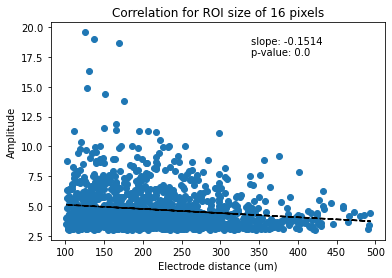

p-value for amp: 5.2080256716118846e-08


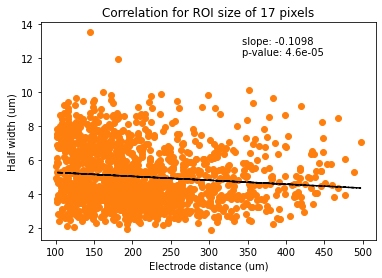

p-value for hw: 4.616619908293778e-05


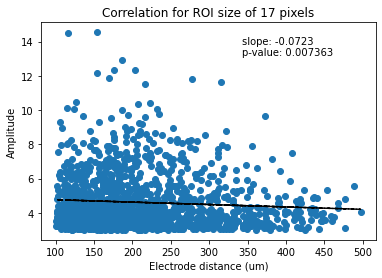

p-value for amp: 0.007362841773888025


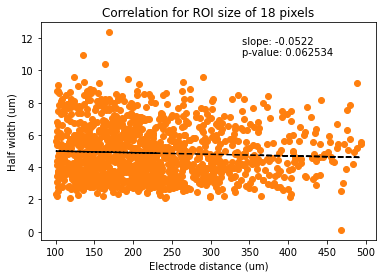

p-value for hw: 0.06253400155865936


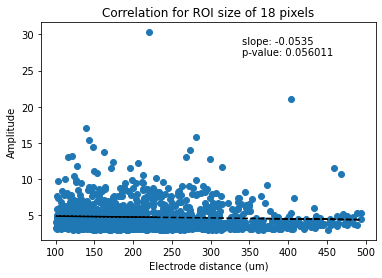

p-value for amp: 0.056010975712219


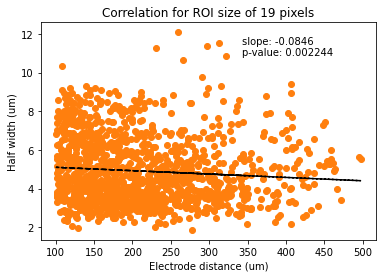

p-value for hw: 0.002244256904719733


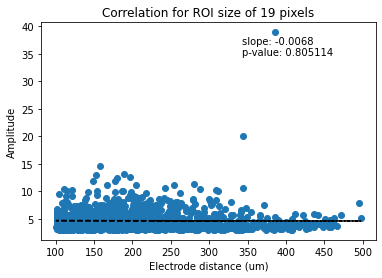

p-value for amp: 0.8051143510119537


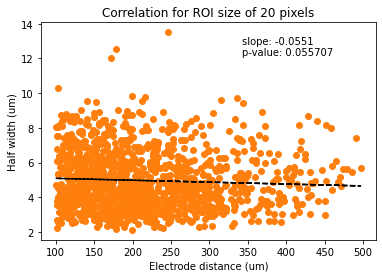

p-value for hw: 0.05570717225518504


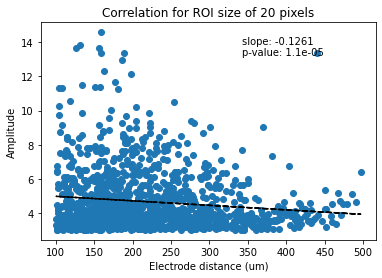

p-value for amp: 1.1142525038188039e-05


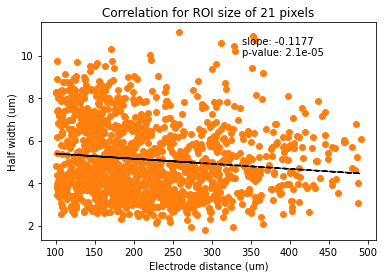

p-value for hw: 2.1068739274272864e-05


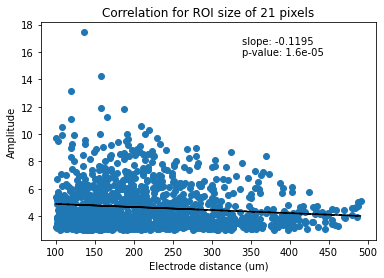

p-value for amp: 1.5610838185707793e-05


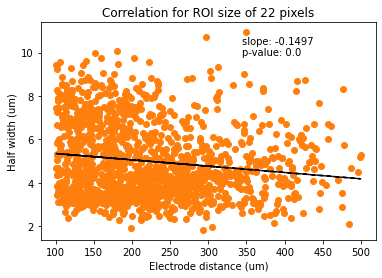

p-value for hw: 6.018508998071453e-08


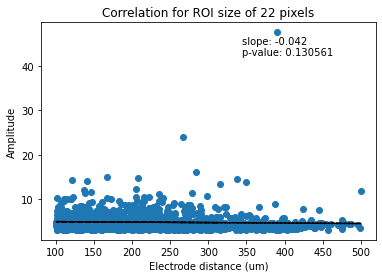

p-value for amp: 0.1305611504036882


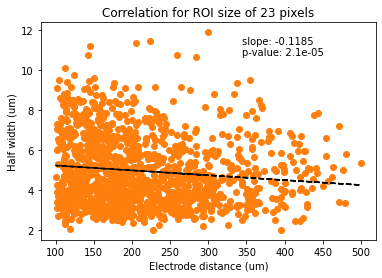

p-value for hw: 2.13731439228241e-05


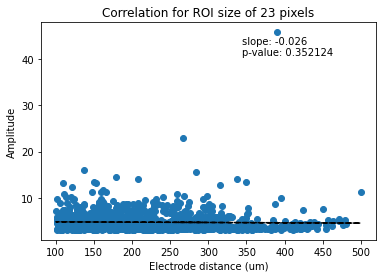

p-value for amp: 0.35212436788719714


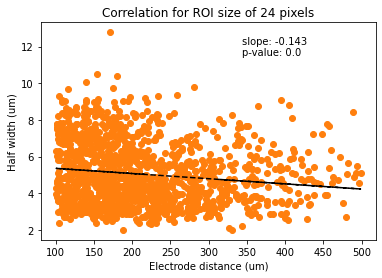

p-value for hw: 2.1048975153921966e-07


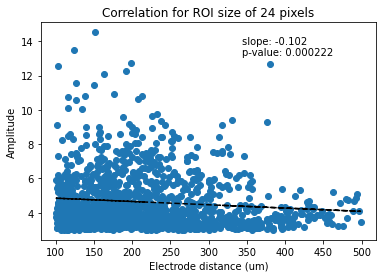

p-value for amp: 0.0002222343434284634


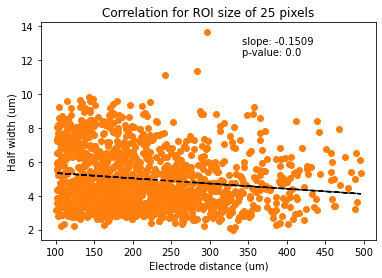

p-value for hw: 1.829549397935718e-08


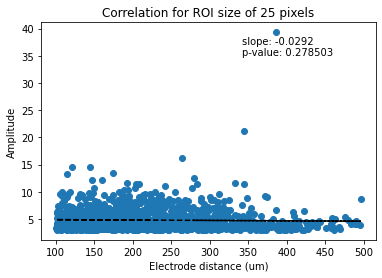

p-value for amp: 0.2785034857473937
Amp counts pos: 1
Amp counts neg: 24
HW counts pos: 0
HW counts neg: 25


In [49]:
# now plot hw vs dist and amp vs dist for each roi size
def compute_correlation(x, y):
    coef = np.polyfit(x, y, 1)
    poly1d_fn = np.poly1d(coef) 
    correlation = np.corrcoef(x, y)[0,1]
    return coef, correlation, poly1d_fn

def plot_correlation(x, y, coef, poly1d_fn, roi_size, y_label, p_value):
    color = 'tab:blue'
    if y_label == "Half width (um)":
        color = 'tab:orange'
    plt.scatter(x, y, color=color)
    slope = round(coef[0], 4)
    plt.plot(x, poly1d_fn(x), '--k', label='Slope:' + str(slope))
    plt.xlabel("Electrode distance (um)")
    plt.ylabel(y_label)
    plt.title("Correlation for ROI size of " + str(roi_size) + " pixels")
    p_value = round(p_value, 6)
    plt.annotate("p-value: " + str(p_value), xy=(0.6, 0.85), xycoords='axes fraction')
    plt.annotate("slope: " + str(slope), xy=(0.6, 0.9), xycoords='axes fraction')
    plt.show()

slopes = {'amp': {
    'r': [],
    'roi_sizes': [],
    'num_points': [],
    'p-value': [],
    'correlation': []
},
        'hw': {
    'r': [],
    'roi_sizes': [],
    'num_points': [],
    'p-value': [],
    'correlation': []
}
}


amp_counts_pos = 0
amp_counts_neg = 0
hw_counts_pos = 0
hw_counts_neg = 0
def compute_and_plot_correlations(slopes, df_rs):
    global amp_counts_pos, amp_counts_neg, hw_counts_pos, hw_counts_neg
    # compute t-test of linear regression using scipy.stats.linregress
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
    # scatter plot: hw vs electrode dist 
    x = df_rs['electrode_dist']
    if len(x) < 1:
        return

    for metric in ['hw', 'amp']:
        coef, correlation, poly1d_fn = compute_correlation(x, df_rs['Value' + metric])
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, df_rs['Value' + metric])
        if p_value < 1:
            if (not (metric == 'hw' and correlation > 0) or (metric == 'amp' and correlation > 0)):
                plot_correlation(x, df_rs['Value' + metric], [correlation], poly1d_fn, roi_size, {'hw' : "Half width (um)", 'amp': "Amplitude"}[metric], p_value)

            if metric == 'amp' and correlation > 0:
                amp_counts_pos += 1
            if metric == 'amp' and correlation < 0:
                amp_counts_neg += 1
            if metric == 'hw' and correlation > 0:
                hw_counts_pos += 1
            if metric == 'hw' and correlation < 0:
                hw_counts_neg += 1

            print("p-value for " + metric + ":", p_value)
            slopes[metric]['r'].append(r_value**2)
            slopes[metric]['correlation'].append(correlation)
            slopes[metric]['p-value'].append(p_value)
            slopes[metric]['roi_sizes'].append(roi_size)
            slopes[metric]['num_points'].append(len(df_rs['electrode_dist']))

for roi_size in roi_sizes:
    df_rs = all_snr[all_snr['roi_size'] == roi_size]
    compute_and_plot_correlations(slopes, df_rs)

print("Amp counts pos:", amp_counts_pos)
print("Amp counts neg:", amp_counts_neg)
print("HW counts pos:", hw_counts_pos)
print("HW counts neg:", hw_counts_neg)
        

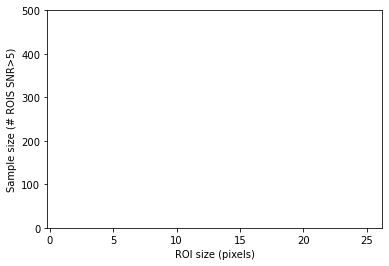

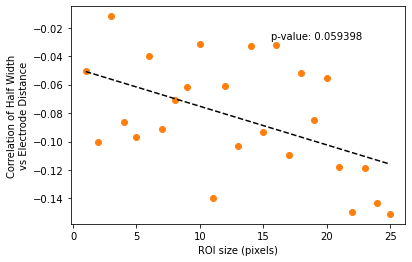

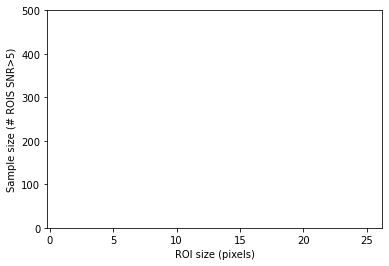

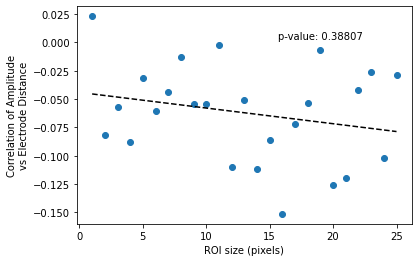

In [47]:
# plot the correlation vs roi_sizes
def plot_correlation_vs_roi(slopes, metric, color, coef, poly1d_fn, p_value):
    plt.clf()
    plt.scatter(slopes['roi_sizes'], slopes['correlation'], color=color)
    slope = round(coef[0], 4)
    plt.plot(slopes['roi_sizes'], poly1d_fn(slopes['roi_sizes']), '--k', label='Slope:' + str(slope))
    plt.xlabel('ROI size (pixels)')
    p_value = round(p_value, 6)
    plt.annotate("p-value: " + str(p_value), xy=(0.6, 0.85), xycoords='axes fraction')
    # plt.annotate("slope: " + str(slope), xy=(0.6, 0.9), xycoords='axes fraction')
    plt.ylabel('Correlation of ' + metric + '\nvs Electrode Distance')
    plt.show()


def plot_num_points_vs_roi(slopes):
    plt.scatter(slopes['roi_sizes'], slopes['num_points'])
    plt.ylim([0,500])
    plt.xlabel('ROI size (pixels)')
    plt.ylabel("Sample size (# ROIS SNR>5)")
    plt.show()

def compute_correlation(x, y):
    coef = np.polyfit(x, y, 1)
    poly1d_fn = np.poly1d(coef) 
    correlation = np.corrcoef(x, y)[0,1]
    return coef, correlation, poly1d_fn


coef_hw, corr_hw, poly1d_fn_hw = compute_correlation(slopes['hw']['roi_sizes'], slopes['hw']['correlation'])
plot_num_points_vs_roi(slopes['hw'])
plot_correlation_vs_roi(slopes['hw'], "Half Width", 'tab:orange', coef_hw, poly1d_fn_hw, slopes['hw']['p-value'][0])

coef_amp, corr_amp, poly1d_fn_amp = compute_correlation(slopes['amp']['roi_sizes'], slopes['amp']['correlation'])
plot_num_points_vs_roi(slopes['amp'])
plot_correlation_vs_roi(slopes['amp'], "Amplitude", 'tab:blue', coef_amp, poly1d_fn_amp, slopes['amp']['p-value'][0])



********************* 29 %, ROI size: 1
p-value for hw: 0.004274641863824584


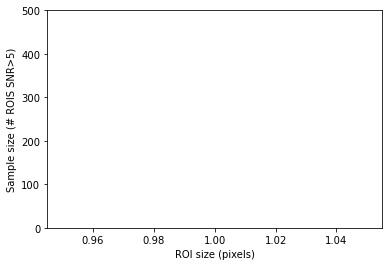

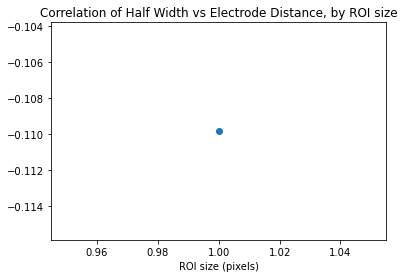

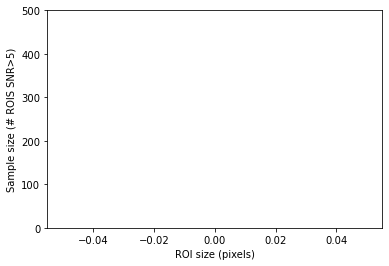

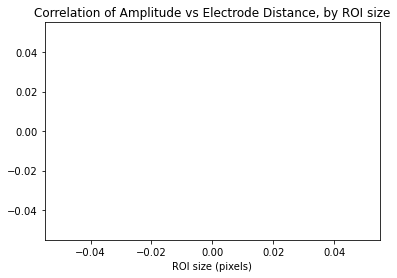



********************* 29 %, ROI size: 2
p-value for hw: 0.0012079903044033599


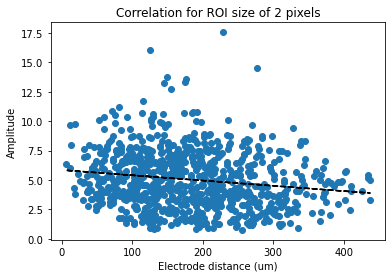

p-value for amp: 2.6869351394055472e-06


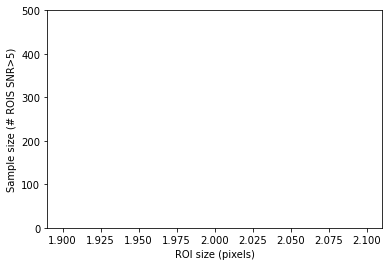

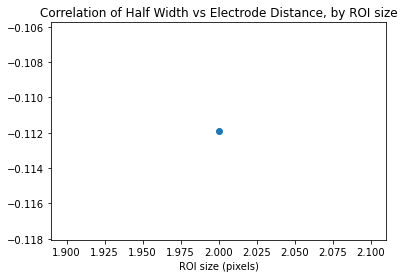

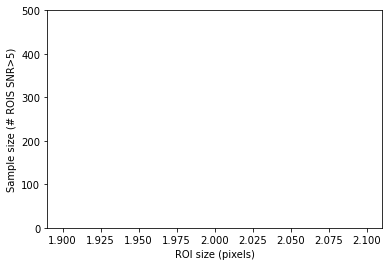

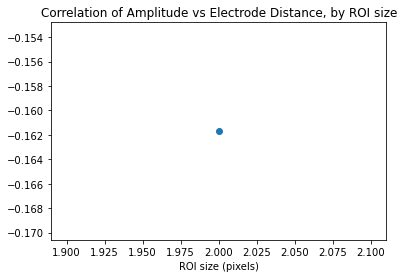



********************* 29 %, ROI size: 3
p-value for hw: 2.9002453362368152e-05


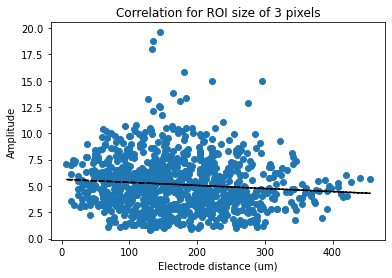

p-value for amp: 0.0028343308103811714


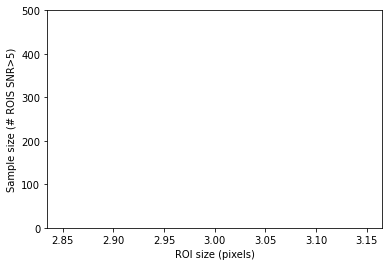

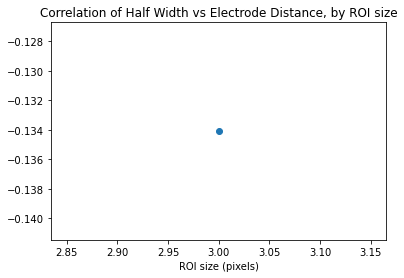

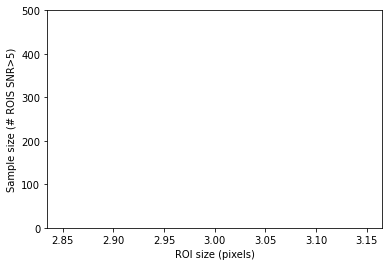

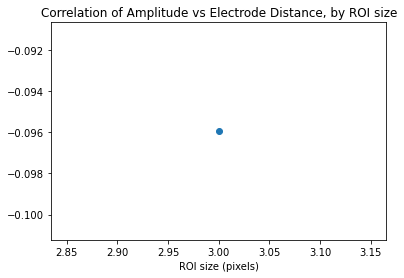



********************* 29 %, ROI size: 4
p-value for hw: 0.00022919529742394053


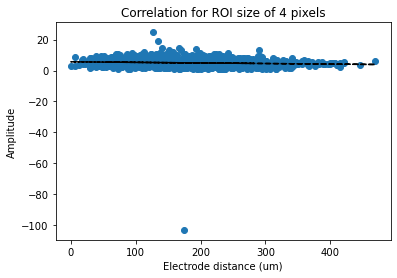

p-value for amp: 0.01523976453010959


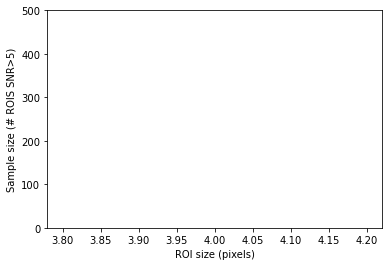

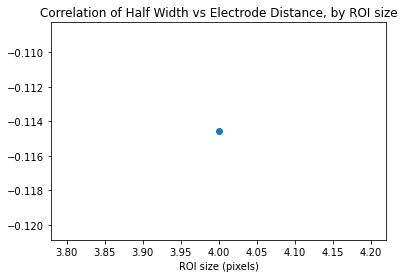

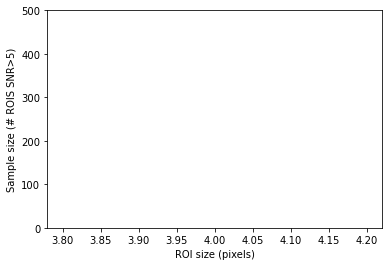

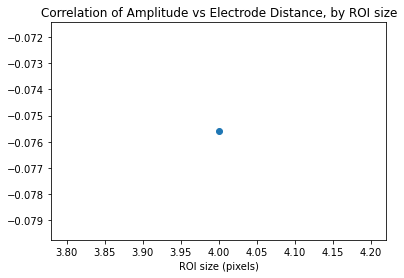



********************* 29 %, ROI size: 5
p-value for hw: 8.6114000502364e-06


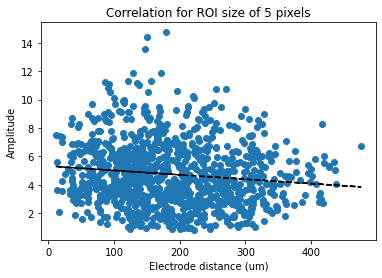

p-value for amp: 9.126283243353552e-05


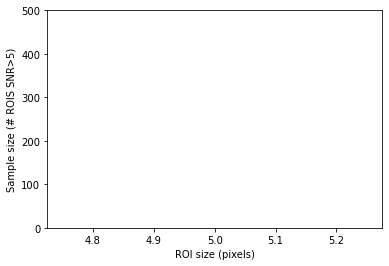

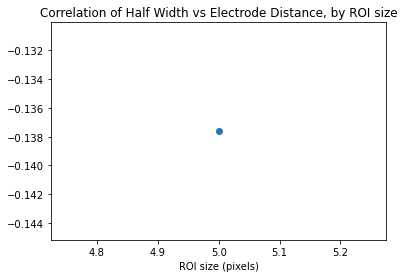

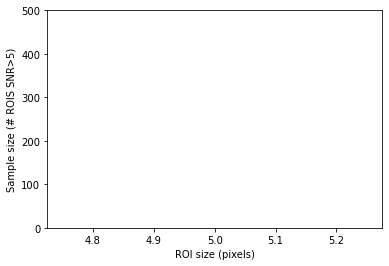

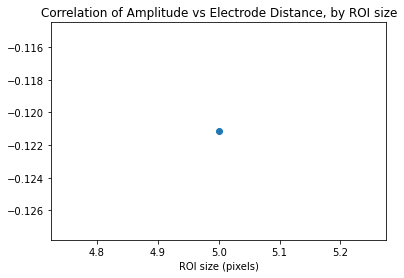



********************* 29 %, ROI size: 6
p-value for hw: 1.4812682470750478e-10


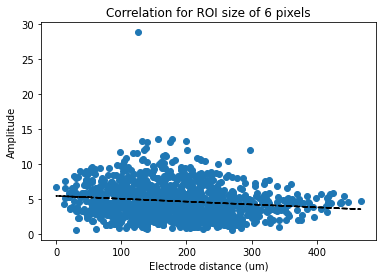

p-value for amp: 1.182864570605852e-06


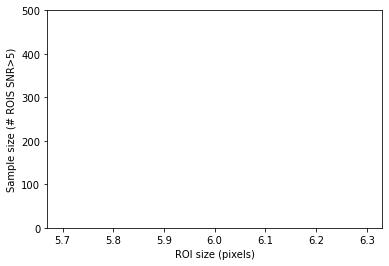

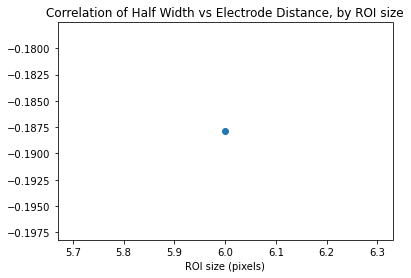

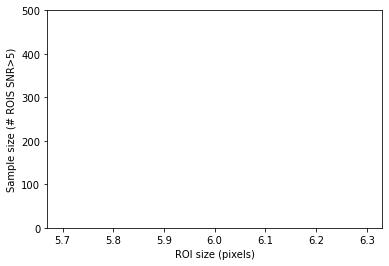

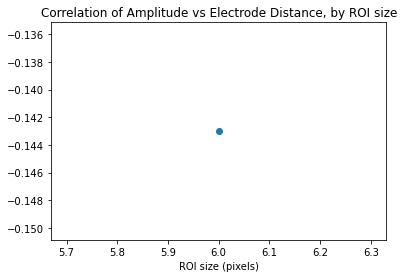



********************* 29 %, ROI size: 7
p-value for hw: 0.00010540665427304427


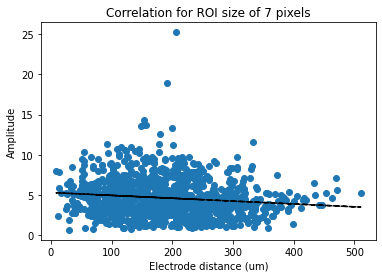

p-value for amp: 7.530185090306155e-06


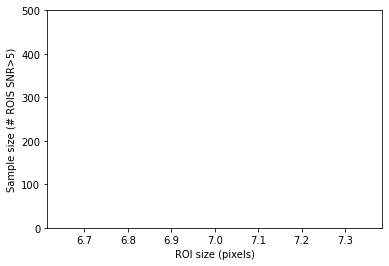

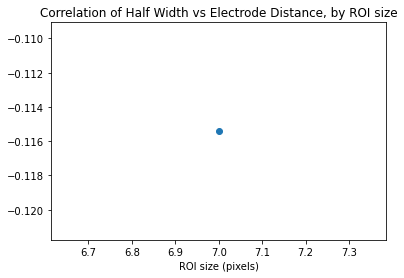

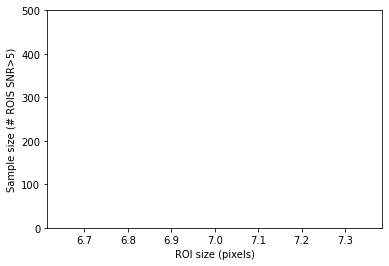

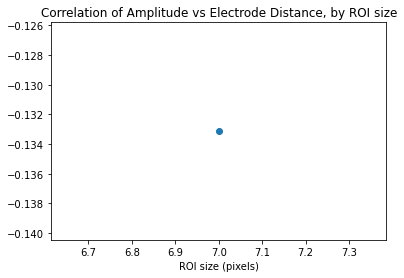



********************* 29 %, ROI size: 8
p-value for hw: 4.497733631946352e-11


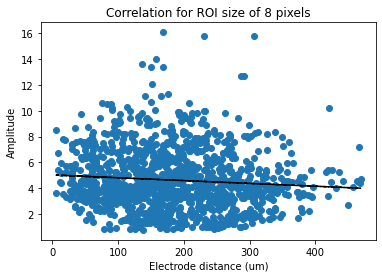

p-value for amp: 0.0025904059035947507


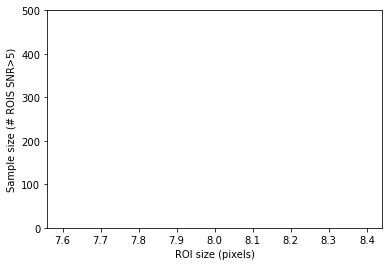

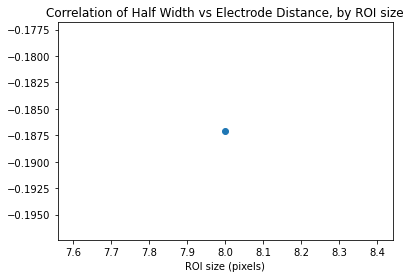

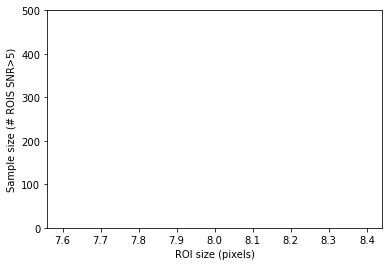

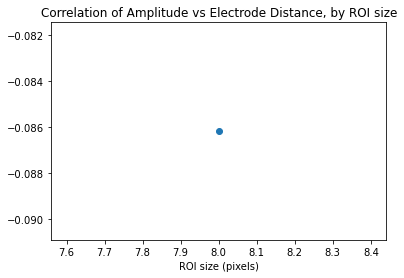



********************* 29 %, ROI size: 9
p-value for hw: 3.284752884413574e-08


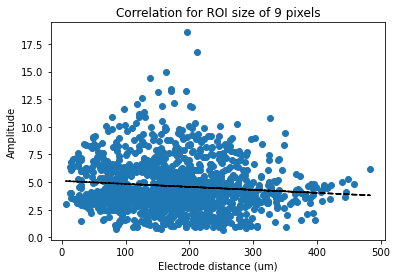

p-value for amp: 0.0003453381230117163


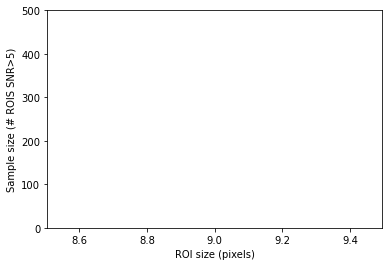

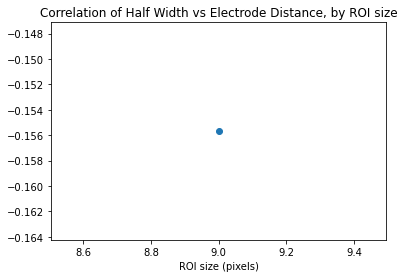

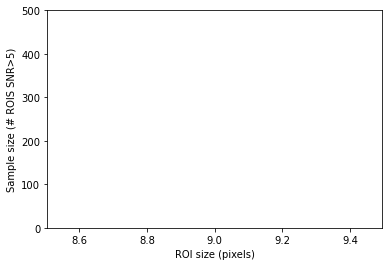

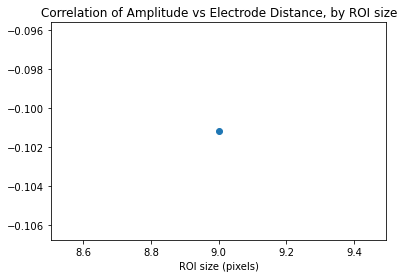



********************* 29 %, ROI size: 10
p-value for hw: 2.9030284758222946e-12


LinAlgError: SVD did not converge in Linear Least Squares

In [9]:
data_agg = {}
snr_cutoffs_titrate.sort(reverse=True)
for snr_cutoff_percentile in snr_cutoffs_titrate:
    if snr_cutoff_percentile not in data_agg:
        data_agg[snr_cutoff_percentile] = {}
    df_snr_cutoff = pre_filter_snr[pre_filter_snr['Value'] > np.percentile(pre_filter_snr['Value'], 100 - snr_cutoff_percentile)]
    
    for roi_size in roi_sizes:
        
        print("\n\n*********************", snr_cutoff_percentile, "%, ROI size:", roi_size)

        df_rs = df_snr_cutoff[df_snr_cutoff['roi_size'] == roi_size]

        slopes = {'amp': {
            'r': [],
            'roi_sizes': [],
            'num_points': [],
            'p-value': [],
            'correlation': []
        },
                'hw': {
            'r': [],
            'roi_sizes': [],
            'num_points': [],
            'p-value': [],
            'correlation': []
        }
        }
        compute_and_plot_correlations(slopes, df_rs)
        plot_num_points_vs_roi(slopes['hw'])
        plot_correlation_vs_roi(slopes['hw'], "Half Width")

        plot_num_points_vs_roi(slopes['amp'])
        plot_correlation_vs_roi(slopes['amp'], "Amplitude")
        
        data_agg[snr_cutoff_percentile][roi_size] = {'hw': slopes['hw']['correlation'],
                                                     'amp': slopes['amp']['correlation']}
        

for snr_cutoff_ in data_agg:
    hw = [data_agg[snr_cutoff_][rs]['hw'][0] for rs in data_agg[snr_cutoff_]]
    amp = [data_agg[snr_cutoff_][rs]['amp'][0] for rs in data_agg[snr_cutoff_]]
    rs = [rs for rs in data_agg[snr_cutoff_]]
    plt.scatter(rs, amp)
    plt.xlabel('ROI size (pixels)')
    plt.title('Correlations of Amplitude vs Distance (SNR cutoff: ' + str(100-snr_cutoff_) + "%)")
    plt.show()

    '''plt.scatter(rs, hw)
    plt.xlabel('ROI size (pixels)')
    plt.title('Correlation of Half-Width vs Distance, (SNR cutoff: ' + str(100-snr_cutoff_) + "%)")
    plt.show()'''